# Capstone Project : Optimizing Growth: Sales and Market Expansion for GIFCO

## Python Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
from pycaret.time_series import *
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Step 1: Data Preprocessing

In [2]:
sales_df = pd.read_csv("Gifco_Sales.csv")
ship_df = pd.read_excel("Final_Capstone.xlsx")

In [3]:
sales_df.head()

,Family,Sub-family,Address,Barcode,Base Unit,Branch,Brand,City,Client Category 1,Client Category 2,...,Amount USD,Gross Amount,Gross Amount LBP,Gross Amount USD,Net Amount,Net Amount LBP,Net Amount USD,Net Quantity,Net Selling,Quantity
0,SEA FREIGHT,CLEARANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,322.25232,28824000,28824000,322.25232,28824000,0,38.98,3,28824000,3
1,SEA FREIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1547,1547,138456500,1547,1717.17,15230215,21.1,2,1547,2
2,SEA FREIGHT,EXPORT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,110,110,9845000,110,110,0,17.69,1,110,1
3,AIR FREIGHT,EXPORT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,10,894500,10,10,0,35.7,1,10,1
4,AIR FREIGHT,EXPORT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26,26,2321800,26,26,0,31.09,1,26,1


In [4]:
ship_df.head()

,Freight Type,Client,Family,Commodity,Packages,Gross Weight,Shipment No.,Date,Shipper,Vessel,From,To
0,Land,TFTAFEH CO.,OTHER,CALCIUM HYPOCHLORITE 65%,44.0,47760.0,PJ/2023/50,21/08/2023,CHLOR PARS CO,NaN,IRN - Islamic Republic of Iran,IRN - Islamic Republic of Iran
1,Land,POWER TECH S.A.L,MACHINES,Batteries,2.0,0.0,PJ/2023/42,28/08/2023,POWER TECH SAL,NaN,LBN - Lebanese Republic,LBN - Lebanese Republic
2,Land,POWER GROUP SARL,STORAGE,Batteries,5.0,0.0,PJ/2023/71,30/08/2023,POWER GROUP SARL,NaN,LBN - Lebanese Republic,LBN - Lebanese Republic
3,Land,POWER GROUP SARL,STORAGE,Batteries,5.0,0.0,PJ/2023/71,30/08/2023,POWER GROUP SARL,NaN,LBN - Lebanese Republic,LBN - Lebanese Republic
4,Land,POWER GROUP SARL,STORAGE,Batteries,5.0,0.0,PJ/2023/71,30/08/2023,POWER GROUP SARL,NaN,LBN - Lebanese Republic,LBN - Lebanese Republic


### Sales Data Cleaning

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13755 entries, 0 to 13754
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Family               13114 non-null  object
 1   Sub-family           13102 non-null  object
 2   Address              1628 non-null   object
 3   Barcode              11 non-null     object
 4   Base Unit            1628 non-null   object
 5   Branch               1628 non-null   object
 6   Brand                1628 non-null   object
 7   City                 79 non-null     object
 8   Client Category 1    1628 non-null   object
 9   Client Category 2    11 non-null     object
 10  Client Category 3    11 non-null     object
 11  Client Code          867 non-null    object
 12  Client ID            1676 non-null   object
 13  Client Name          1676 non-null   object
 14  Cost Center          1694 non-null   object
 15  Cur                  1934 non-null   object
 16  Date

In [6]:
# First Step is to drop unnecessary columns
cols_drop_sales = ['Client Category 1', 'Client Category 2', 'Client Category 3', 'Client Code', 'Client ID', 'Client Name', 'Address', 'Barcode', 
                   'Cost Center', 'Base Unit', 'Branch', 'Project', 'City', 'Cur', 'Product Description', 'Project', 'Unit', 'Amount', 'Amount  LBP',
                   'Gross Amount', 'Gross Amount  LBP', 'Net Amount', 'Net Amount  LBP', 'Net Quantity', 'Net Selling', 'Brand', 'Date', 'Invoice', 'Product Code']

sales_data_clean = sales_df.drop(columns=cols_drop_sales, errors='ignore')

In [7]:
sales_data_clean.head()

,Family,Sub-family,Product Name,Year,Amount USD,Gross Amount USD,Net Amount USD,Quantity
0,SEA FREIGHT,CLEARANCE,CUSTOM CLEARANCE FORMALITIES - IMPORT,2019,322.25232,322.25232,38.98,3
1,SEA FREIGHT,NaN,STORAGE AT JADRA (VAT),2019,1547,1547,21.1,2
2,SEA FREIGHT,EXPORT,ENERGY CONSUMPTION AT PORT,2019,110,110,17.69,1
3,AIR FREIGHT,EXPORT,SECURITY FOR AIR FREIGHT CARGO,2019,10,10,35.7,1
4,AIR FREIGHT,EXPORT,CUSTOM CLEARANCE FORMALITIES AT,2019,26,26,31.09,1


In [8]:
sales_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13755 entries, 0 to 13754
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Family             13114 non-null  object
 1   Sub-family         13102 non-null  object
 2   Product Name       13755 non-null  object
 3   Year               13755 non-null  object
 4   Amount  USD        13755 non-null  object
 5   Gross Amount  USD  13755 non-null  object
 6   Net Amount  USD    13755 non-null  object
 7   Quantity           13755 non-null  object
dtypes: object(8)
memory usage: 859.8+ KB


In [9]:
# Now we need to deal with missing values in Sales
# Impute missing values in Family with the mode
family_mode = sales_data_clean['Family'].mode()[0]
sales_data_clean['Family'] = sales_data_clean['Family'].fillna(family_mode)

# Impute missing values in Sub-family with the mode
sub_family_mode = sales_data_clean['Sub-family'].mode()[0]
sales_data_clean['Sub-family'] = sales_data_clean['Sub-family'].fillna(sub_family_mode)

In [10]:
null_sales = sales_data_clean.isnull().sum()
print('The number of missing values is: ', null_sales)

The number of missing values is:  Family               0
Sub-family           0
Product Name         0
Year                 0
Amount  USD          0
Gross Amount  USD    0
Net Amount  USD      0
Quantity             0
dtype: int64


### Feature Engineering

In [11]:
# Columns to convert to float
to_float = ['Amount  USD', 'Gross Amount  USD', 'Net Amount  USD', 'Quantity']

# Convert columns to float
for col in to_float:
    sales_data_clean[col] = pd.to_numeric(sales_data_clean[col], errors='coerce')

In [12]:
# Profit Margin
sales_data_clean['Profit Margin'] = (sales_data_clean['Net Amount  USD'] - sales_data_clean['Gross Amount  USD']) / sales_data_clean['Gross Amount  USD']

# Average Price per Unit
sales_data_clean['Average Price'] = sales_data_clean['Net Amount  USD'] / sales_data_clean['Quantity']

In [13]:
sales_data_clean.head()

,Family,Sub-family,Product Name,Year,Amount USD,Gross Amount USD,Net Amount USD,Quantity,Profit Margin,Average Price
0,SEA FREIGHT,CLEARANCE,CUSTOM CLEARANCE FORMALITIES - IMPORT,2019,322.25232,322.25232,38.98,3.0,-0.879039,12.993333
1,SEA FREIGHT,EXPORT,STORAGE AT JADRA (VAT),2019,1547.00000,1547.00000,21.10,2.0,-0.986361,10.550000
2,SEA FREIGHT,EXPORT,ENERGY CONSUMPTION AT PORT,2019,110.00000,110.00000,17.69,1.0,-0.839182,17.690000
3,AIR FREIGHT,EXPORT,SECURITY FOR AIR FREIGHT CARGO,2019,10.00000,10.00000,35.70,1.0,2.570000,35.700000
4,AIR FREIGHT,EXPORT,CUSTOM CLEARANCE FORMALITIES AT,2019,26.00000,26.00000,31.09,1.0,0.195769,31.090000


In [14]:
sales_data_clean["Sub-family"] = sales_data_clean["Sub-family"].replace({"STORAGE AT JIYEH": "JIYEH"})

print(sales_data_clean["Sub-family"].value_counts())

Sub-family
EXPORT               8338
IMPORT               3518
CLEARANCE            1459
COCODILLE             318
JIYEH                 108
Sub-family             11
LOCAL TRANSPORTAT       3
Name: count, dtype: int64


In [15]:
sales_data_clean["Family"] = sales_data_clean["Sub-family"].replace({"STORAGE AT JIYEH": "JIYEH"})

### Shipment Data Cleaning

In [16]:
ship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12536 entries, 0 to 12535
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Freight Type  12536 non-null  object 
 1   Client        12482 non-null  object 
 2   Family        12464 non-null  object 
 3   Commodity     12483 non-null  object 
 4   Packages      12465 non-null  float64
 5   Gross Weight  12465 non-null  float64
 6   Shipment No.  12466 non-null  object 
 7   Date          12466 non-null  object 
 8   Shipper       12327 non-null  object 
 9   Vessel        1291 non-null   object 
 10  From          12479 non-null  object 
 11  To            12477 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.1+ MB


In [17]:
ship_data_clean = ship_df.copy()

In [18]:
# Drop rows where Client is null
ship_data_clean = ship_data_clean.dropna(subset=['Client'])

In [19]:
# Create a mapping of unique Client names to Client IDs
client_mapping = {client: f"Client_{idx+1}" for idx, client in enumerate(ship_df['Client'].unique())}

# Replace the Client names with Client IDs
ship_data_clean['Client'] = ship_data_clean['Client'].map(client_mapping)

In [20]:
# Convert Date to datetime format
ship_data_clean['Date'] = pd.to_datetime(ship_data_clean['Date'], errors='coerce', dayfirst=True)

In [21]:
ship_data_clean['Year'] = ship_data_clean['Date'].dt.year
ship_data_clean['Month'] = ship_data_clean['Date'].dt.month

In [22]:
ship_data_clean['Vessel'] = ship_data_clean['Vessel'].apply(lambda x: 'CMA CGM' if isinstance(x, str) and 'CMA CGM' in x else x)

In [23]:
# Save a copy for EDA later on
vessel_copy = ship_data_clean['Vessel'].copy()

In [24]:
# We then need to drop unnecessary columns
cols_drop_ship = ['Shipment No.', 'Vessel', 'Date']

ship_data_clean = ship_data_clean.drop(columns=cols_drop_ship, errors='ignore')

In [25]:
# Now we need to handle missing values: imputing by mode (categorical) or median (numerical)
cat_col = ['Family', 'Commodity', 'Shipper', 'From', 'To', 'Year', 'Month']
for col in cat_col:
    mode_value = ship_data_clean[col].mode()[0]
    ship_data_clean[col] = ship_data_clean[col].fillna(mode_value)

In [26]:
# Impute missing values for numerical columns with median
num_col = ['Packages', 'Gross Weight']
for col in num_col:
    median_value = ship_data_clean[col].median()
    ship_data_clean[col] = ship_data_clean[col].fillna(median_value)

In [27]:
null_ship = ship_data_clean.isnull().sum()
print('The number of missing values is: ', null_ship)

The number of missing values is:  Freight Type    0
Client          0
Family          0
Commodity       0
Packages        0
Gross Weight    0
Shipper         0
From            0
To              0
Year            0
Month           0
dtype: int64


### Feature Engineering

In [28]:
# Route
ship_data_clean['Route'] = ship_data_clean['From'] + " → " + ship_data_clean['To']

# Weight per Package
ship_data_clean['Weight per Package'] = ship_data_clean['Gross Weight'] / ship_data_clean['Packages']

# Shipment Season
ship_data_clean['Season'] = ship_data_clean['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2]
                                                                      else 'Spring' if x in [3, 4, 5]
                                                                      else 'Summer' if x in [6, 7, 8]
                                                                      else 'Fall')


In [29]:
ship_data_clean.head()

,Freight Type,Client,Family,Commodity,Packages,Gross Weight,Shipper,From,To,Year,Month,Route,Weight per Package,Season
0,Land,Client_1,OTHER,CALCIUM HYPOCHLORITE 65%,44.0,47760.0,CHLOR PARS CO,IRN - Islamic Republic of Iran,IRN - Islamic Republic of Iran,2023.0,8.0,IRN - Islamic Republic of Iran → IRN - Islamic...,1085.454545,Summer
1,Land,Client_2,MACHINES,Batteries,2.0,0.0,POWER TECH SAL,LBN - Lebanese Republic,LBN - Lebanese Republic,2023.0,8.0,LBN - Lebanese Republic → LBN - Lebanes...,0.000000,Summer
2,Land,Client_3,STORAGE,Batteries,5.0,0.0,POWER GROUP SARL,LBN - Lebanese Republic,LBN - Lebanese Republic,2023.0,8.0,LBN - Lebanese Republic → LBN - Lebanes...,0.000000,Summer
3,Land,Client_3,STORAGE,Batteries,5.0,0.0,POWER GROUP SARL,LBN - Lebanese Republic,LBN - Lebanese Republic,2023.0,8.0,LBN - Lebanese Republic → LBN - Lebanes...,0.000000,Summer
4,Land,Client_3,STORAGE,Batteries,5.0,0.0,POWER GROUP SARL,LBN - Lebanese Republic,LBN - Lebanese Republic,2023.0,8.0,LBN - Lebanese Republic → LBN - Lebanes...,0.000000,Summer


In [30]:
ship_data_clean['Family'].value_counts()

Family
STORAGE                   4132
MACHINES                  2531
TRANSPORTATION            1253
FRUITS AND VEGETABLES      885
GENERATOR                  779
Batteries                  756
PREPARED FOODSTUFF         586
Construction Materials     518
LOGISTIC                   282
PAPERS                     251
TRADING                    118
PRINTED MATTERS            113
ELECTRONICS                 88
FURNITURE                   48
OTHER                       42
VEHICLES                    31
COSMATICS                   21
PIPES / TILES               20
CLOTHES AND TEXTURES         7
HOUSEHOLD                    3
MEDICAL TOOLS                3
PERSONAL EFFECTS             2
TOYS                         2
SOLAR                        2
Miscellanous                 2
Consolidation                1
BEVERAGES                    1
EMPLOYEE                     1
MECHINERY                    1
FOODSTUFF                    1
PREPARED                     1
EQUIPMENT                    1
N

In [31]:
family_mapping = {
    "GENERATOR": "MACHINES",
    "LOGISTIC": "TRADING",
    "CLOTHES AND TEXTURES": "COSMATICS",
    "PAPERS": "PRINTED MATTERS",
    "HOUSEHOLD": "FURNITURE",
    "MEDICAL TOOLS": "OTHER",
    "TOYS": "STORAGE",
    "SOLAR": "STORAGE",
    "MECHINERY": "MACHINES",
    "FOODSTUFF": "PREPARED FOODSTUFF",
    "PREPARED ": "PREPARED FOODSTUFF",
    "EQUIPMENT": "FURNITURE",
    "Miscellanous": "STORAGE",
    "Consolidation": "TRADING",
    "BEVERAGES": "PREPARED FOODSTUFF",
    "EMPLOYEE": "OTHER",
    "PERSONAL EFFECTS": "OTHER"
}

In [32]:
ship_data_clean["Family"] = ship_data_clean["Family"].replace(family_mapping)

print(ship_data_clean["Family"].value_counts())

Family
STORAGE                   4138
MACHINES                  3311
TRANSPORTATION            1253
FRUITS AND VEGETABLES      885
Batteries                  756
PREPARED FOODSTUFF         589
Construction Materials     518
TRADING                    401
PRINTED MATTERS            364
ELECTRONICS                 88
FURNITURE                   52
OTHER                       48
VEHICLES                    31
COSMATICS                   28
PIPES / TILES               20
Name: count, dtype: int64


In [76]:
from_mapping = {
    "IRN - Islamic Republic of Iran": "Iran",
    "LBN - Lebanese RepublicÂ Â Â Â Â Â Â ": "Lebanon",
    "LBN - Lebanese RepublicÂ\xa0Â\xa0Â\xa0Â\xa0Â\xa0Â\xa0Â\xa0 ": "Lebanon",
    "LBN - Lebanese Republic": "Lebanon",
    "LBN - Lebanese ": "Lebanon",
    "RepublicÂ Â Â Â Â Â Â ": "Lebanon",
    "DAC-Shahjalal International Ai": "Bangladesh",
    "BEY-Beirut Rafic Hariri Intern": "Lebanon",
    "SHA-Shanghai Hongqiao Internat": "China",
    "CGH-Congonhas/S?o Paulo Nation": "Brazil",
    "GYY-Gary/Chicago International": "USA",
    "HKG-Hong Kong International Ai": "Hong Kong",
    "HDD-Hyderabad Airport": "India",
    "JLX-Los Angeles Union Station": "USA",
    "LEB-Lebanon Municipal Airport": "USA",
    "PVG-Shanghai Pudong Internatio": "China",
    "IST-Istanbul AtatÃ¼rk AirportÂ (": "Turkey",
    "TRR-China Bay Airport": "Sri Lanka",
    "UTO-Indian Mountain LRRS Airpo": "USA",
    "Beijing - China": "China",
    "CAN-Guangzhou Baiyun Internati": "China",
    "SMF-Sacramento International A": "USA",
    "AMS-Amsterdam Airport Schiphol": "Netherlands",
    "HCM - Ho Chi Minh  - Vietman": "Vietnam",
    "ICN-Incheon International Airp": "South Korea",
    "MUC-Munich AirportÂ (succeededÂ ": "Germany",
    "XSI-South Indian Lake Airport": "Canada",
    "JUB-Juba Airport": "South Sudan",
    "ARN-Stockholm Arlanda Airport": "Sweden",
    "STR-Stuttgart Airport": "Germany",
    "DXB-Dubai International Airpor": "UAE",
    "FTN-FREETOWN": "Sierra Leone",
    "ATH-Athens International Airpo": "Greece",
    "LOS-Murtala Muhammed Internati": "Nigeria",
    "REO-Rome State Airport": "Italy",
    "VIE-Vienna International Airpo": "Austria",
    "BCN-Barcelona El Prat Airport": "Spain",
    "TPE-Taiwan Taoyuan Internation": "Taiwan",
    "MAD-Madridâ€“Barajas Airport": "Spain",
    "CAI-Cairo International Airpor": "Egypt",
    "LAX-Los Angeles International": "USA",
    "FRA-Frankfurt Airport": "Germany",
    "LYA-Luoyang Beijiao Airport": "China",
    "CGO-Zhengzhou Xinzheng Interna": "China",
    "MAA-Chennai International Airp": "India",
    "MNL-Ninoy Aquino International": "Philippines",
    "SZX-Shenzhen Bao'an Internatio": "China",
    "ORD-O'Hare International": "USA",
    "YIW-Yiwu Airport": "China",
    "KUW-KUWAIT": "Kuwait",
    "BEY-Beirut": "Lebanon",
    "GEM-Gemlik": "Turkey",
    "SHK-Shekou": "China",
    "SHA-Shanghai": "China",
    "XMN-Xiamen": "China",
    "JEA-Jebel Ali": "UAE",
    "ALX-Alexandria": "Egypt",
    "NGB-Ningbo": "China",
    "TPP-Tanjung Priok": "Indonesia",
    "CIR-Cairo": "Egypt",
    "PER-Perawang": "Indonesia",
    "AMB-Ambarli": "Turkey",
    "RTM-Rotterdam": "Netherlands",
    "MIL-Milano": "Italy",
    "HBQ-Hamburg": "Germany",
    "ZHE-Zhenjiang": "China",
    "DAM-Damietta": "Egypt",
    "RDS-Rades/Tunis": "Tunisia",
    "NVS-Novorossiysk": "Russia",
    "NWY-New York": "USA",
    "IST-Istanbul": "Turkey",
    "NKG-Nanjing": "China",
    "RAU-Rauma (Raumo)": "Finland",
    "PUS-Busan (ex Pusan)": "South Korea",
    "TIP-Tripoli": "Libya",
    "PBL-Puerto Cabello": "Venezuela",
    "YTN-Yantian": "China",
    "MSY-New Orleans": "USA",
    "ABJ-Abidjan": "Ivory Coast",
    "MTR-Montreal": "Canada",
    "ATU-Tsingtao / Qingdao": "China",
    "HKG-Hong Kong": "Hong Kong",
    "ANR-Antwerp / Antwerpen": "Belgium",
    "IZT-Izmit": "Turkey",
    "PSD-Port Said": "Egypt",
    "NSA-Jawaharlal Nehru (Nhava Sh": "India",
    "BAS-Xingang / Tienjinxingang": "China",
    "YPT-Tsingtao / Qingdao": "China",
    "YPG-Yangpu": "China",
    "ABG-Chinkiang / Zhenjiang": "China",
    "SAV-Savannah": "USA",
    "BAV-Amoy / Xiamen": "China",
    "ALH-Alexandria / El Iskandariy": "Egypt",
    "GOA-Genoa": "Italy",
    "SZX-Shenzhen": "China",
    "JMN-Jiangmen": "China",
    "CLL-Callao": "Peru",
    "MUN-Mundra": "India",
    "APP-Apapa": "Nigeria",
    "SAL-Salerno Port": "Italy",
    "LEI-Leixoes": "Portugal",
    "OSL-Oslo": "Norway",
    "BEIRUT": "Lebanon",
    "SIN-Singapore": "Singapore",
    "NRK-Norrkoping": "Sweden",
    "SSZ-Santos": "Brazil",
    "CGU-Changshu": "China",
    "PIR-Piraeus": "Greece",
    "EYP-Evyap": "Turkey",
    "Bei-Beirut - Free Zone": "Lebanon",
    "NSA-Nansha": "China",
    "FOS-Fos sur Mer": "France",
    "EWR-Newark apt": "USA",
    "BKK-Bangkok": "Thailand",
    "JKT-Jakarta, Java": "Indonesia",
    "NOR-Norfolk": "USA",
    "MBA-Mombasa": "Kenya",
    "LIS-Lisbon / Lisboa": "Portugal",
    "SUB-Surabaya, Java": "Indonesia",
    "NVO-Nuova Olonio": "Italy",
    "PET-Petersberg": "Germany",
    "MARDAS": "Turkey",
    "LSQ-Los Angeles": "USA",
    "EPT-Tsingtao / Qingdao": "China",
    "QIW-Tsingtao / Qingdao" :"China",
    "DAZ-Chinkiang / Zhenjiang" :"China",
    "ARS-Arsta/Stockholm": "Sweden",
    "SRG-Semarang, Java" : "Indonesia",
    "BHI-Xingang / Tienjinxingang" : "China",
    "KOP-Koper" : "Slovenia",
    'LCH-Laem Chabang': 'Thailand',
    'TEK-Tekirdag': 'Turkey',
    'CND-Constanta': 'Romania',
    'VCI-Venice': 'Italy',
    'EMN-Nema': 'Mauritania',
    'HPH-Haiphong': 'Vietnam',
    'ALY-Alexandria / El Iskandariy': 'Egypt',
    'HMQ-Hamburg': 'Germany',
    'SIE-Sines': 'Portugal',
    'BOM-Mumbai (Ex Bombay)': 'India',
    'TAI-Taiz': 'Yemen',
    'RAU-Rauma': 'Finland',
    'RAN-Ravenna': 'Italy',
    'MIA-Miami': 'USA',
    'SWK-Shuwaikh': 'Kuwait',
    'IJX-Jacksonville': 'USA',
    'DRZ-Venice / Venezia': 'Italy',
}

In [77]:
to_mapping = {
    "IRN - Islamic Republic of Iran": "Iran",
    "LBN - Lebanese RepublicÂ Â Â Â Â Â Â ": "Lebanon",
    "LBN - Lebanese Republic ": "Lebanon",
    "LBN - Lebanese ": "Lebanon",
    "RepublicÂ Â Â Â Â Â Â ": "Lebanon",
    "BEY-Beirut Rafic Hariri Intern": "Lebanon",
    "DOH-DOHA INTERNATIONAL AIRPORT": "Qatar",
    "KUW-KUWAIT": "Kuwait",
    "MCT-Muscat International Airpo": "Oman",
    "KWI-Kuwait International Airpo": "Kuwait",
    "LBV-Libreville International A": "Gabon",
    "DLA-Douala Airport": "Cameroon",
    "BNI-Benin City Airport": "Nigeria",
    "Conakry - Guinea": "Guinea",
    "BEY-Beirut Rafic ": "Lebanon",
    "AMS-Amsterdam Airport Schiphol": "Netherlands",
    "DTW-Detroit Metropolitan Wayne": "USA",
    "EMI-Emirau Airport": "Papua New Guinea",
    "BRU-Brussels AirportÂ (Zaventem": "Belgium",
    "Cotonou - Benin": "Benin",
    "BER-Berlin Brandenburg Airport": "Germany",
    "PHC-Port Harcourt Internationa": "Nigeria",
    "JDN-Jordan Airport": "Jordan",
    "LSZ-Mali Losinj Airport": "Croatia",
    "YYZ-Toronto Pearson Internatio": "Canada",
    "Dakar, Senegal": "Senegal",
    "ARN-Stockholm Arlanda Airport": "Sweden",
    "ABJ-Port Bouet AirportÂ (Felix": "Ivory Coast",
    "IST-Istanbul AtatÃ¼rk AirportÂ (": "Turkey",
    "BAH-Bahrain International Airp": "Bahrain",
    "MPM-Maputo International Airpo": "Mozambique",
    "JUB-Juba Airport": "South Sudan",
    "HAH-Prince Said Ibrahim Intern": "Comoros",
    "FIH-N'djili AirportÂ (Kinshasa": "DR Congo",
    "BHZ-All airports": "Brazil",
    "YYC-Calgary International Airp": "Canada",
    "GVA-Cointrin International Air": "Switzerland",
    "YMX-MontrÃ©al-Mirabel Internati": "Canada",
    "DXB-Dubai International Airpor": "UAE",
    "SHJ-Sharjah International Airp": "UAE",
    "VIE-Vienna International Airpo": "Austria",
    "EBL-Erbil International Airpor": "Iraq",
    "HGH-Hangzhou Xiaoshan Internat": "China",
    "KHI-Jinnah International Airpo": "Pakistan",
    "CIR-Cairo Regional Airport": "Egypt",
    "AUH-Abu Dhabi International Ai": "UAE",
    "PSD-Port Said": "Egypt",
    "BEY-Beirut": "Lebanon",
    "HAMAD": "Qatar",
    "JEA-Jebel Ali": "UAE",
    "SAA-Shuaiba": "Kuwait",
    "DKR-Dakar": "Senegal",
    "MAT-Matadi": "DR Congo",
    "ABJ-Abidjan": "Ivory Coast",
    "SOH-Sohar": "Oman",
    "SBA-Shuaiba": "Kuwait",
    "LMS-Limassol": "Cyprus",
    "MLB-Melbourne": "Australia",
    "TIP-Tripoli": "Libya",
    "FNA-Freetown": "Sierra Leone",
    "JKT-Jakarta, Java": "Indonesia",
    "TRIPOLI-LY": "Libya",
    "SUB-Surabaya, Java": "Indonesia",
    "JIB-Djibouti": "Djibouti",
    "DAR-Dar Es Salaam": "Tanzania",
    "TRP-Tripolis": "Libya",
    "ASK-Yamoussoukro": "Ivory Coast",
    "CMB-Colombo": "Sri Lanka",
    "MBA-Mombasa": "Kenya",
    "APP-Apapa": "Nigeria",
    "ALG-Alger": "Algeria",
    "NGB-Ningbo": "China",
    "GNC-Conakry": "Guinea",
    "TEM-Tema": "Ghana",
    "MTR-Montreal": "Canada",
    "CHI-Chicago": "USA",
    "SWK-Shuwaikh": "Kuwait",
    "FXT-Felixstowe": "UK",
    "MER-Mersin": "Turkey",
    "NVS-Novorossiysk": "Russia",
    "TOD-Toronto": "Canada",
    "Bei-Beirut - Free Zone": "Lebanon",
    "OXB-Bissau": "Guinea-Bissau",
    "alb-Durres": "Albania",
    "FIH-Kinshasa": "DR Congo",
    "cmd-Douala": "Cameroon",
    "ANR-Antwerp / Antwerpen": "Belgium",
    "NSA-Jawaharlal Nehru (Nhava Sh": "India",
    "MEL-Melbourne": "Australia",
    "DAM-Damascus": "Syria",
    "LBV-Libreville": "Gabon",
    "SHK-Shekou": "China",
    "LFW-Lome": "Togo",
    "SLL-Salalah": "Oman",
    "MLW-Monrovia": "Liberia",
    "KYE-Tripoli": "Libya",
    "PNR-Pointe Noire": "Congo",
    "RAU-Rauma": "Finland",
    "MRA-Misurata": "Libya",
    "DAM-Damietta": "Egypt",
    "PIY-Pt Ivory": "Ivory Coast",
    "AMB-Ambarli": "Turkey",
    "JUM-Juba": "South Sudan",
    "HMD-Hamada": "Japan",
    "HSO-Houston": "USA",
    "NWY-New York": "USA",
    "LTK-Latakia": "Syria",
    "CHI-China": "China",
    "HAM-Hamburg": "Germany"
}


In [ ]:
# Apply the mapping to the 'To' column
ship_data_clean['From'] = ship_data_clean['From'].map(from_mapping).fillna(ship_data_clean['From'])
ship_data_clean['To'] = ship_data_clean['To'].map(to_mapping).fillna(ship_data_clean['To'])

#### Save the cleaned Datasets Localy

In [33]:
sales_data_clean.to_csv("sales_clean.csv", index=False)
ship_data_clean.to_csv("ship_clean.csv", index=False)

## Step 2: Explanatory Data Analysis

### Sales Data EDA

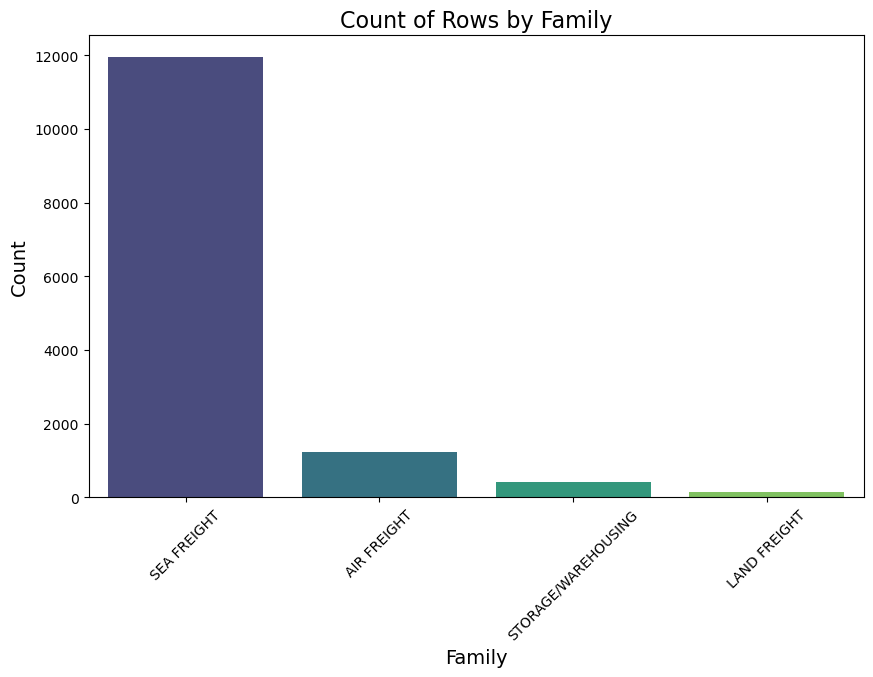

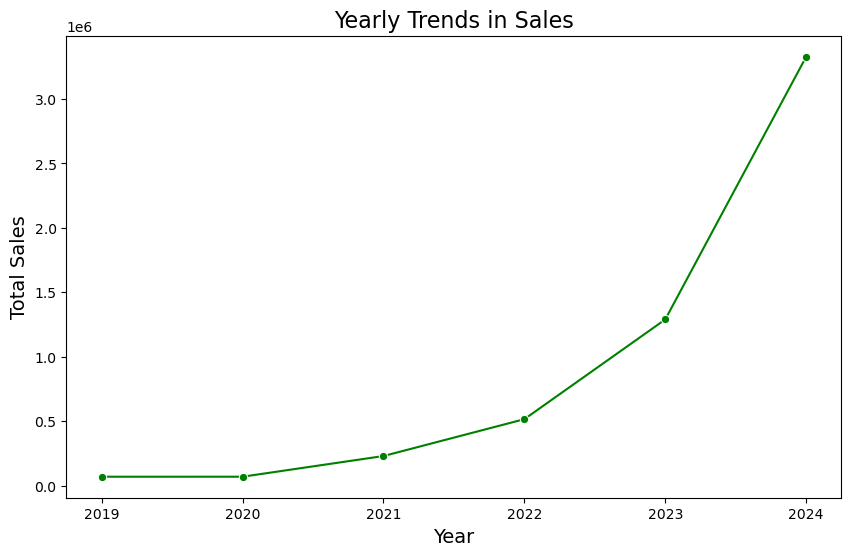

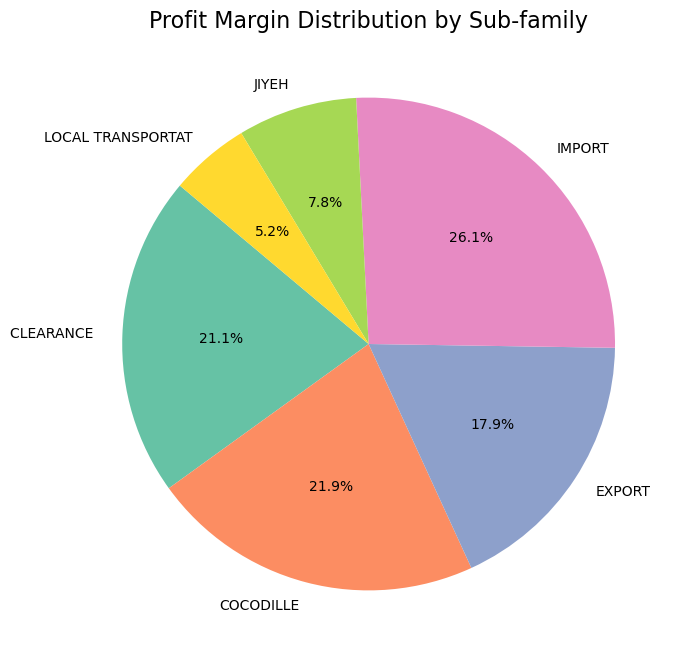

In [46]:
# Group and count rows based on Family
sales_data = pd.read_csv('sales_clean.csv')
family_counts = sales_data['Family'].value_counts().reset_index()
family_counts.columns = ['Family', 'Count']

# Plot the count of rows for each Family
plt.figure(figsize=(10, 6))
sns.barplot(data=family_counts, x='Family', y='Count', palette="viridis")
plt.title('Count of Rows by Family', fontsize=16)
plt.xlabel('Family', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 3. Yearly Trends in Net Amount USD
yearly_trends = sales_data.groupby('Year')['Net Amount  USD'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_trends, x='Year', y='Net Amount  USD', marker='o', color='green')
plt.title('Yearly Trends in Sales', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.show()

# Pie Chart for Average Profit Margin by Sub-family
sub_family_profit = sales_data.groupby('Sub-family')['Net Amount  USD'].mean()

plt.figure(figsize=(8, 8))
plt.pie(sub_family_profit, labels=sub_family_profit.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2", len(sub_family_profit)))
plt.title('Profit Margin Distribution by Sub-family', fontsize=16)
plt.show()

### Shipments Data EDA

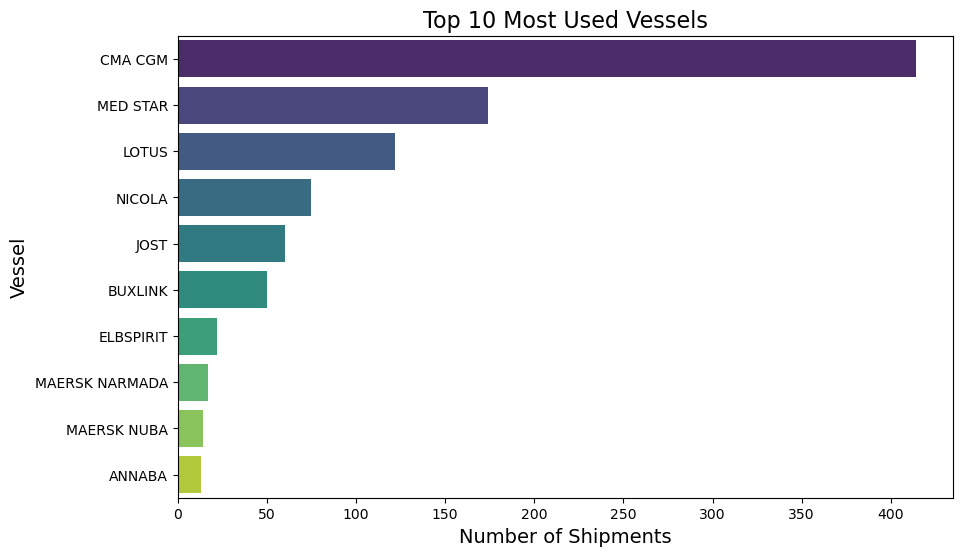

In [47]:
vessel_counts_grouped = vessel_copy.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=vessel_counts_grouped.head(10).values, y=vessel_counts_grouped.head(10).index, palette="viridis")
plt.title('Top 10 Most Used Vessels', fontsize=16)
plt.xlabel('Number of Shipments', fontsize=14)
plt.ylabel('Vessel', fontsize=14)
plt.show()


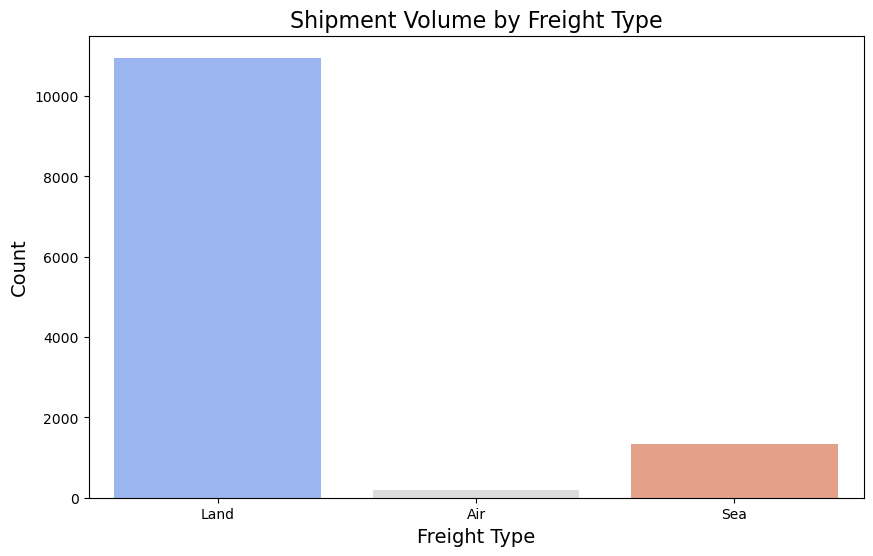

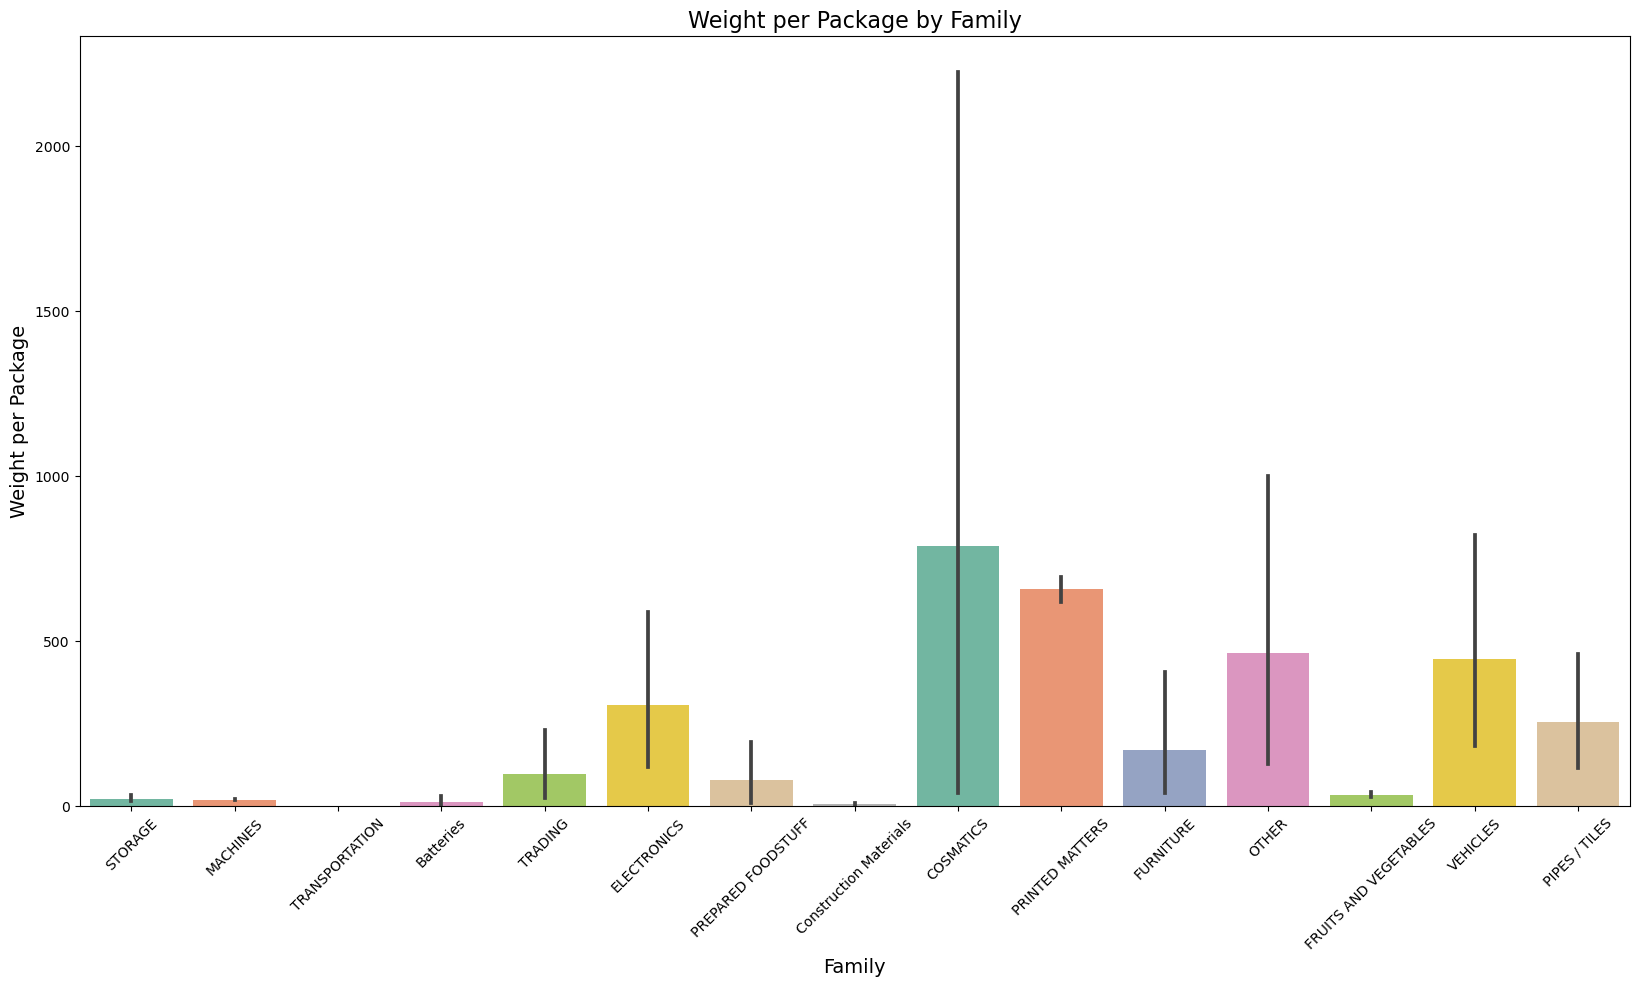

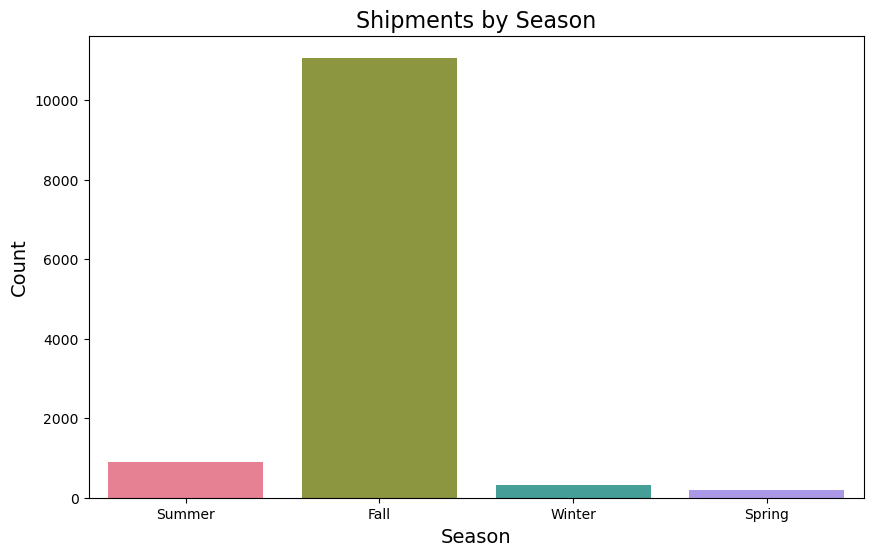

In [48]:
ship_data = pd.read_csv('ship_clean.csv')

# Shipment Volume by Freight Type
plt.figure(figsize=(10, 6))
sns.countplot(data=ship_data, x='Freight Type', palette="coolwarm")
plt.title('Shipment Volume by Freight Type', fontsize=16)
plt.xlabel('Freight Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Weight per Package by Family
plt.figure(figsize=(20, 10))
sns.barplot(data=ship_data, x='Family', y='Weight per Package', palette="Set2")
plt.title('Weight per Package by Family', fontsize=16)
plt.xlabel('Family', fontsize=14)
plt.ylabel('Weight per Package', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Shipments by Season
plt.figure(figsize=(10, 6))
sns.countplot(data=ship_data, x='Season', palette="husl")
plt.title('Shipments by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()


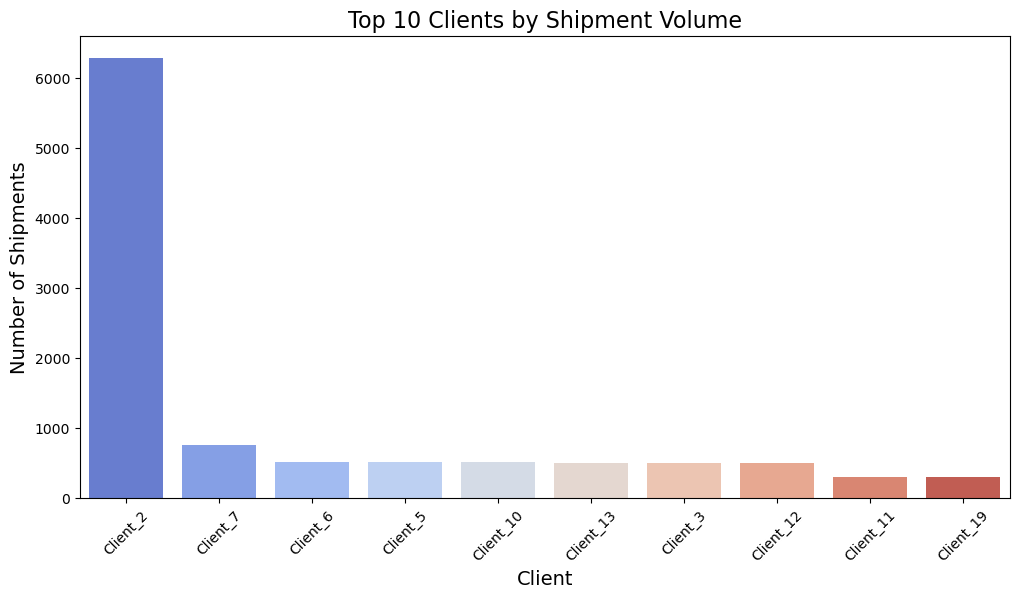

In [38]:
# Count the number of shipments per client
client_shipment_counts = ship_data_clean['Client'].value_counts().reset_index()
client_shipment_counts.columns = ['Client', 'Shipment Count']

# Plot the top clients
plt.figure(figsize=(12, 6))
sns.barplot(data=client_shipment_counts.head(10), x='Client', y='Shipment Count', palette="coolwarm")
plt.title('Top 10 Clients by Shipment Volume', fontsize=16)
plt.xlabel('Client', fontsize=14)
plt.ylabel('Number of Shipments', fontsize=14)
plt.xticks(rotation=45)
plt.show()


## Step 3: Sales Forecasting

In [3]:
sales_data = pd.read_csv('sales_clean.csv')

In [4]:
sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y')

In [5]:
sales_ts = sales_data.groupby('Year')['Net Amount  USD'].sum().reset_index()
sales_ts.set_index('Year', inplace=True)

### SARIMA Model

In [6]:
sarima_model = SARIMAX(sales_ts, 
                       order=(2,1,2),      
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit()

forecast_periods = 6
sarima_forecast = sarima_fit.forecast(steps=forecast_periods)

### ARIMA Model

In [7]:
# Apply ARIMA for time-series forecasting
arima_model = ARIMA(sales_ts, order=(2,1,2))
arima_fit = arima_model.fit()

# Forecasting next 5 years
forecast_periods = 6
arima_forecast = arima_fit.forecast(steps=forecast_periods)

### Exponential Smoothing Model

In [8]:
# Apply Exponential Smoothing for alternative forecasting
exp_model = ExponentialSmoothing(sales_ts, trend='add', seasonal='add', seasonal_periods=3)
exp_fit = exp_model.fit()

# Forecasting next 5 years
exp_forecast = exp_fit.forecast(steps=forecast_periods)

### Holt-Winters Model

In [9]:
holtwinters_model = ExponentialSmoothing(
    sales_ts['Net Amount  USD'],
    trend='add',
    seasonal='add',
    seasonal_periods=2
)

holtwinters_fit = holtwinters_model.fit()
forecast_periods = 6
holtwinters_forecast = holtwinters_fit.forecast(steps=forecast_periods)

### Prophet Model

In [10]:
# Initialize and fit Prophet model
sales_ts_prophet = sales_data.groupby('Year')['Net Amount  USD'].sum().reset_index()
sales_ts_prophet.rename(columns={"Year": "ds", "Net Amount  USD": "y"}, inplace=True)
prophet_model = Prophet()
prophet_model.fit(sales_ts_prophet)

future = prophet_model.make_future_dataframe(periods=forecast_periods, freq='Y')
forecast = prophet_model.predict(future)
future_years = future['ds']

16:01:26 - cmdstanpy - INFO - Chain [1] start processing
16:01:27 - cmdstanpy - INFO - Chain [1] done processing


### Theta Model

In [11]:
s = setup(data=sales_ts, target='Net Amount  USD', fold=3)
theta_model = create_model('theta')
forecast_periods = 6
theta_forecast = predict_model(theta_model, fh=forecast_periods)

,Description,Value
0,session_id,4822
1,Target,Net Amount USD
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(6, 1)"
5,Transformed data shape,"(6, 1)"
6,Transformed train set shape,"(5, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2020,1596.2631,1596.2631,160344.6303,160344.6303,0.6985,1.0734
1,2021,2.5702,1.8186,206320.4476,206320.4476,0.4002,0.5003
2,2022,4.1996,3.3016,625090.7512,625090.7512,0.4847,0.6398
Mean,NaT,534.3443,533.7944,330585.2764,330585.2764,0.5278,0.7378
SD,NaT,750.8903,751.2790,209090.9690,209090.9690,0.1255,0.2440


### Grouping Models

In [ ]:
future_years = pd.date_range(start=sales_ts.index[-1] + pd.DateOffset(years=1), periods=forecast_periods, freq='Y')

arima_forecast_values = arima_forecast[:forecast_periods]
prophet_forecast_values = forecast['yhat'][-forecast_periods:].values
sarima_forecast_values = sarima_fit.forecast(steps=forecast_periods)
holtwinters_forecast_values = holtwinters_forecast[:forecast_periods]
theta_forecast_values = theta_forecast['y_pred'][:forecast_periods]

forecast_df = pd.DataFrame({
    'Year': future_years,
    'ARIMA Forecast': arima_forecast_values,
    'SARIMA Forecast': sarima_forecast_values,
    'Prophet Forecast': prophet_forecast_values,
    'Holt Winters Forecast': holtwinters_forecast_values,
    'Theta Forecast': theta_forecast_values
})

forecast_df.set_index('Year', inplace=True)

## Individual Model Forecasting Visualization

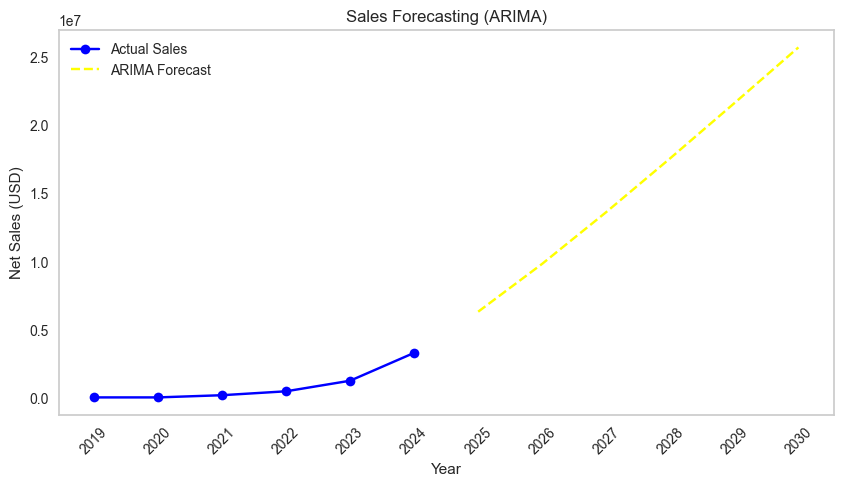

In [15]:
combined_sales = pd.concat([sales_ts, forecast_df])
combined_sales.index = pd.to_datetime(combined_sales.index, errors='coerce')

plt.figure(figsize=(10, 5))
plt.plot(combined_sales.index.year, combined_sales['Net Amount  USD'], label='Actual Sales', marker='o', color='blue')
plt.plot(combined_sales.index.year, combined_sales['ARIMA Forecast'], label='ARIMA Forecast', linestyle='--', color='yellow')
plt.xticks(combined_sales.index.year, combined_sales.index.year, rotation=45)
plt.title('Sales Forecasting (ARIMA)')
plt.xlabel('Year')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid(False)
plt.show()

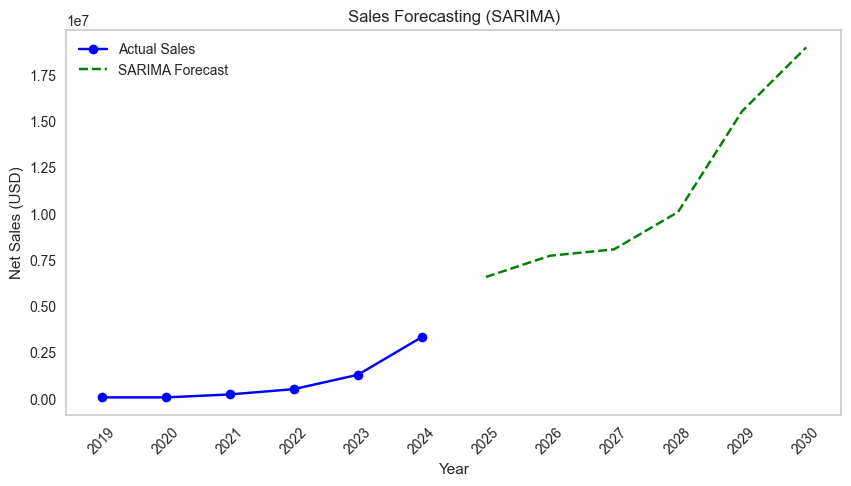

In [58]:
combined_sales = pd.concat([sales_ts, forecast_df])
combined_sales.index = pd.to_datetime(combined_sales.index, errors='coerce')

plt.figure(figsize=(10, 5))
plt.plot(combined_sales.index.year, combined_sales['Net Amount  USD'], label='Actual Sales', marker='o', color='blue')
plt.plot(combined_sales.index.year, combined_sales['SARIMA Forecast'], label='SARIMA Forecast', linestyle='--', color='green')
plt.xticks(combined_sales.index.year, combined_sales.index.year, rotation=45)
plt.title('Sales Forecasting (SARIMA)')
plt.xlabel('Year')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid(False)
plt.show()

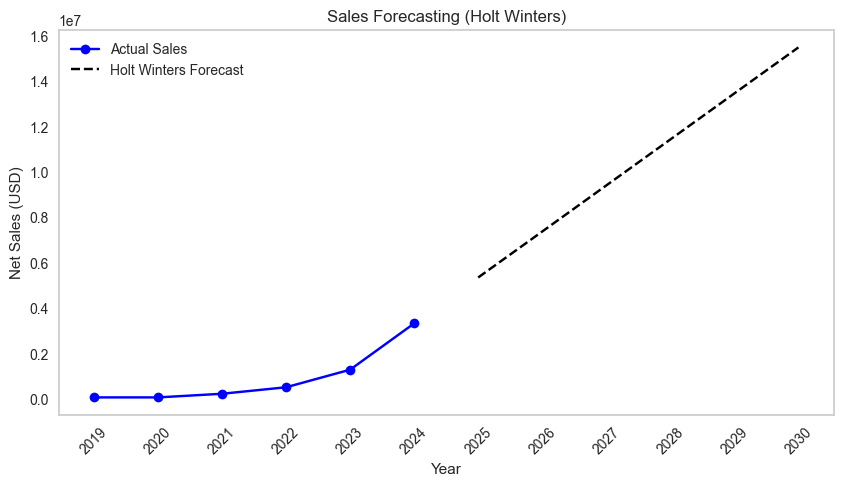

In [18]:
combined_sales = pd.concat([sales_ts, forecast_df])
combined_sales.index = pd.to_datetime(combined_sales.index, errors='coerce')

plt.figure(figsize=(10, 5))
plt.plot(combined_sales.index.year, combined_sales['Net Amount  USD'], label='Actual Sales', marker='o', color='blue')
plt.plot(combined_sales.index.year, combined_sales['Holt Winters Forecast'], label='Holt Winters Forecast', linestyle='--', color='black')
plt.xticks(combined_sales.index.year, combined_sales.index.year, rotation=45)
plt.title('Sales Forecasting (Holt Winters)')
plt.xlabel('Year')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid(False)
plt.show()


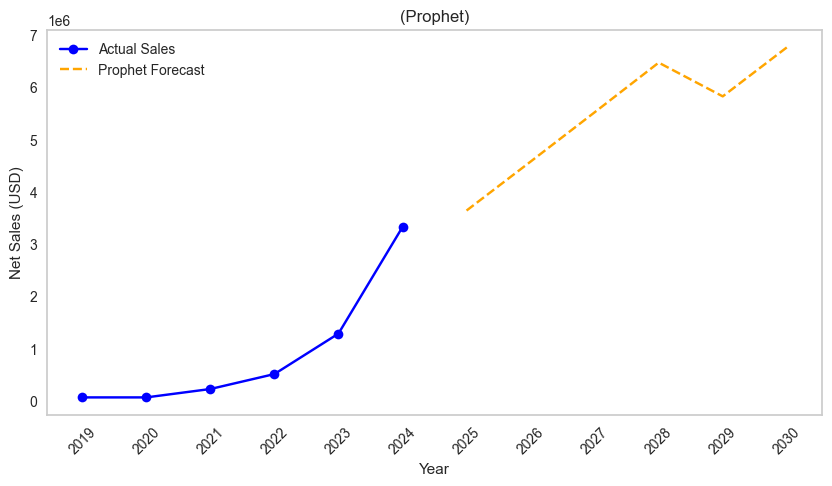

In [20]:
combined_sales = pd.concat([sales_ts, forecast_df])
combined_sales.index = pd.to_datetime(combined_sales.index, errors='coerce')

plt.figure(figsize=(10, 5))
plt.plot(combined_sales.index.year, combined_sales['Net Amount  USD'], label='Actual Sales', marker='o', color='blue')
plt.plot(combined_sales.index.year, combined_sales['Prophet Forecast'], label='Prophet Forecast', linestyle='--', color='orange')
plt.xticks(combined_sales.index.year, combined_sales.index.year, rotation=45)
plt.title('(Prophet)')
plt.xlabel('Year')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid(False)
plt.show()


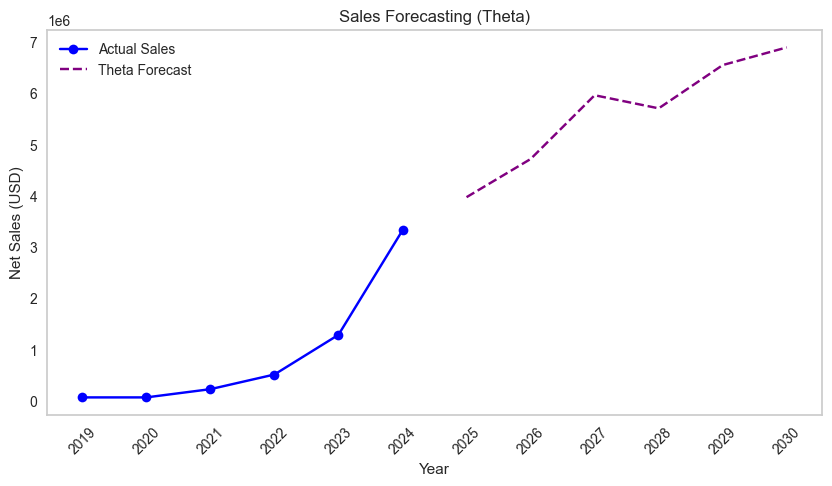

In [52]:
combined_sales = pd.concat([sales_ts, forecast_df])
combined_sales.index = pd.to_datetime(combined_sales.index, errors='coerce')

plt.figure(figsize=(10, 5))
plt.plot(combined_sales.index.year, combined_sales['Net Amount  USD'], label='Actual Sales', marker='o', color='blue')
plt.plot(combined_sales.index.year, combined_sales['Theta Forecast'], label='Theta Forecast', linestyle='--', color='purple')
plt.xticks(combined_sales.index.year, combined_sales.index.year, rotation=45)
plt.title('Sales Forecasting (Theta)')
plt.xlabel('Year')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid(False)
plt.show()


## All Model Forcasting Visualization

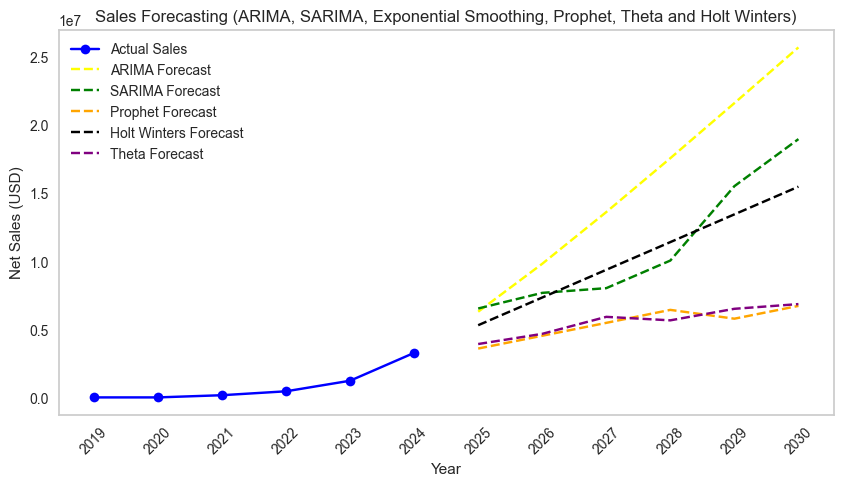

In [59]:
combined_sales = pd.concat([sales_ts, forecast_df])
combined_sales.index = pd.to_datetime(combined_sales.index, errors='coerce')

plt.figure(figsize=(10, 5))
plt.plot(combined_sales.index.year, combined_sales['Net Amount  USD'], label='Actual Sales', marker='o', color='blue')
plt.plot(combined_sales.index.year, combined_sales['ARIMA Forecast'], label='ARIMA Forecast', linestyle='--', color='yellow')
plt.plot(combined_sales.index.year, combined_sales['SARIMA Forecast'], label='SARIMA Forecast', linestyle='--', color='green')
plt.plot(combined_sales.index.year, combined_sales['Prophet Forecast'], label='Prophet Forecast', linestyle='--', color='orange')
plt.plot(combined_sales.index.year, combined_sales['Holt Winters Forecast'], label='Holt Winters Forecast', linestyle='--', color='black')
plt.plot(combined_sales.index.year, combined_sales['Theta Forecast'], label='Theta Forecast', linestyle='--', color='purple')
plt.xticks(combined_sales.index.year, combined_sales.index.year, rotation=45)
plt.title('Sales Forecasting (ARIMA, SARIMA, Exponential Smoothing, Prophet, Theta and Holt Winters)')
plt.xlabel('Year')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
# Evaluate forecasting accuracy using last known actual data
actual_values = sales_ts[-forecast_periods:]
arima_rmse = np.sqrt(mean_squared_error(actual_values, arima_forecast[:len(actual_values)]))
sarima_rmse = np.sqrt(mean_squared_error(actual_values, sarima_forecast[:len(actual_values)]))
prophet_forecast_values = forecast['yhat'][-forecast_periods:].values
prophet_rmse = np.sqrt(mean_squared_error(actual_values, prophet_forecast_values))
theta_forecast_values = theta_forecast['y_pred'][:forecast_periods]
theta_rmse = np.sqrt(mean_squared_error(actual_values, theta_forecast_values))
holtwinters_rmse = np.sqrt(mean_squared_error(actual_values, holtwinters_forecast_values))

print(f"Prophet RMSE: {prophet_rmse/6:.2f}")
print(f"SARIMA RMSE: {sarima_rmse/6:.2f}")
print(f"ARIMA RMSE: {arima_rmse/6:.2f}")
print(f"Theta RMSE: {theta_rmse/6:.2f}")
print(f"Holt Winters RMSE: {holtwinters_rmse/6:.2f}")

Prophet RMSE: 773059.15
SARIMA RMSE: 445764.96
ARIMA RMSE: 2650975.42
Theta RMSE: 189453.56
Holt Winters RMSE: 1639931.79


## Best Model OPtimization

Since the best model was the theta model, we need to optimize it to find the best hyperparameters.


In [ ]:
s = setup(data=sales_ts, target='Net Amount USD', fold=3)

param_grid = {
    'seasonality': ['add', 'mul'],  
    'trend': ['add', 'mul'],        
    'seasonal_periods': [4, 6, 12]
}

def grid_search_theta(data, param_grid, forecast_periods):
    best_score = float('inf')
    best_params = None
    
    for params in ParameterGrid(param_grid):
      model = create_model('theta', seasonal=params['seasonality'], trend=params['trend'], seasonal_periods=params['seasonal_periods'])
      model_fit = model.fit()
      forecast = predict_model(model_fit, fh=forecast_periods)
      rmse = np.sqrt(mean_squared_error(forecast['yhat'], actual_values[-forecast_periods:]))
      if rmse < best_score:
          best_score = rmse
          best_params = params
    
    return best_params, best_score

best_params, best_score = grid_search_theta(sales_ts, param_grid, forecast_periods=6)

print(f"Best Theta Model Hyperparameters: {best_params}")
print(f"Best RMSE: {best_score}")

Best Theta Model Hyperparameters: 'seasonality': 'add', 'trend': 'add', 'seasonal_periods': 12
Best RMSE: 189453.56


## Best Model Visualization

It turns out the default model gave the best RMSE so we can now visualize the best model which the default Theta Model.

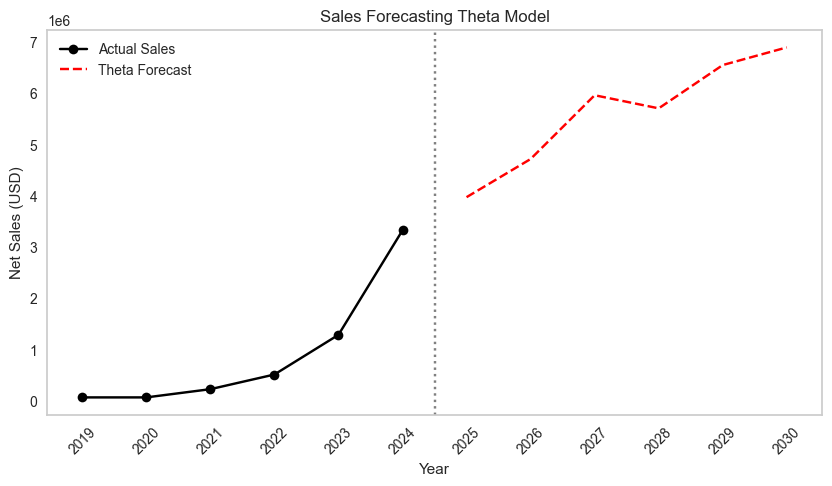

In [60]:
combined_sales = pd.concat([sales_ts, forecast_df])
combined_sales.index = pd.to_datetime(combined_sales.index, errors='coerce')

plt.figure(figsize=(10, 5))
plt.plot(combined_sales.index.year, combined_sales['Net Amount  USD'], label='Actual Sales', marker='o', color='black')
plt.plot(combined_sales.index.year, combined_sales['Theta Forecast'], label='Theta Forecast', linestyle='--', color='red')
plt.axvline(x=2024.5, color='gray', linestyle=':')
plt.xticks(combined_sales.index.year, combined_sales.index.year, rotation=45)
plt.title('Sales Forecasting Theta Model')
plt.xlabel('Year')
plt.ylabel('Net Sales (USD)')
plt.legend()
plt.grid(False)
plt.show()